In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
kickstarter_data_path = 'Kickstarter.xlsx'
kickstarter_df = pd.read_excel(kickstarter_data_path)

In [14]:

# Data Preprocessing

# Filter observations where 'state' is either 'successful' or 'failed'
filtered_df = kickstarter_df[kickstarter_df['state'].isin(['successful', 'failed'])]



In [15]:

# Check for missing values in the filtered dataset
missing_values_before = filtered_df.isnull().sum()


In [16]:

# Handling Missing Values
# Removing rows with missing 'name' as they are crucial for project identification
filtered_df = filtered_df.dropna(subset=['name'])
# Filling missing 'category' with 'Unknown' as it's a categorical variable
filtered_df['category'] = filtered_df['category'].fillna('Unknown')
# Check for missing values after handling
missing_values_after = filtered_df.isnull().sum()



In [17]:
# Enhancing the code with additional feature engineering and data cleaning
# Data Cleaning Removing negative or zero goals as they are not logical
filtered_df = filtered_df[filtered_df['goal'] > 0]



In [18]:
# Feature Engineering

# Extracting additional time-related features
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])
filtered_df['launched_at'] = pd.to_datetime(filtered_df['launched_at'])

# Month, day, and year of creation and launch
filtered_df['created_at_month'] = filtered_df['created_at'].dt.month
filtered_df['created_at_day'] = filtered_df['created_at'].dt.day
filtered_df['created_at_year'] = filtered_df['created_at'].dt.year
filtered_df['launched_at_month'] = filtered_df['launched_at'].dt.month
filtered_df['launched_at_day'] = filtered_df['launched_at'].dt.day
filtered_df['launched_at_year'] = filtered_df['launched_at'].dt.year

# Duration between creation and launch in days
filtered_df['days_between_creation_and_launch'] = (filtered_df['launched_at'] - filtered_df['created_at']).dt.days

# Dropping the original datetime columns as they are no longer needed
filtered_df = filtered_df.drop(['created_at', 'launched_at'], axis=1)

# Re-checking for any remaining missing values or logical inconsistencies
missing_values_check = filtered_df.isnull().sum()
logical_inconsistencies_check = (filtered_df.select_dtypes(include=['float64', 'int64']) < 0).sum()

# Displaying the results of the additional data cleaning and feature engineering
missing_values_check, logical_inconsistencies_check, filtered_df.head()

(id                                  0
 name                                0
 goal                                0
 pledged                             0
 state                               0
 disable_communication               0
 country                             0
 currency                            0
 deadline                            0
 state_changed_at                    0
 staff_pick                          0
 backers_count                       0
 static_usd_rate                     0
 usd_pledged                         0
 category                            0
 spotlight                           0
 name_len                            0
 name_len_clean                      0
 blurb_len                           0
 blurb_len_clean                     0
 deadline_weekday                    0
 state_changed_at_weekday            0
 created_at_weekday                  0
 launched_at_weekday                 0
 deadline_month                      0
 deadline_day            

In [19]:
# Dropping irrelevant columns
# Dropping columns that are not relevant or not available at the time of project launch
columns_to_drop = ['id', 'pledged', 'backers_count', 'usd_pledged', 'spotlight', 'state_changed_at', 'deadline']
filtered_df = filtered_df.drop(columns=columns_to_drop)



In [20]:
# Handling Categorical Variables - One-Hot Encoding
categorical_columns = ['country', 'currency', 'category']
for col in categorical_columns:
    dummies = pd.get_dummies(filtered_df[col], prefix=col)
    filtered_df = pd.concat([filtered_df.drop(col, axis=1), dummies], axis=1)



In [21]:
# Import LabelEncoder from sklearn
from sklearn.preprocessing import LabelEncoder

# Binary Encoding for the Target Variable
label_encoder = LabelEncoder()
filtered_df['state'] = label_encoder.fit_transform(filtered_df['state'])

# Print the class mapping for the 'state' variable
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)







{'failed': 0, 'successful': 1}


In [22]:
# Splitting the data into features (X) and target variable (y)
X = filtered_df.drop(['name', 'state'], axis=1)
y = filtered_df['state']


In [23]:
# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying the shapes of the training and test sets along with missing values information
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)
print("Missing values before handling:", missing_values_before)
print("Missing values after handling:", missing_values_after)


Training set shape: (10747, 85) Test set shape: (2687, 85)
Missing values before handling: id                                0
name                              1
goal                              0
pledged                           0
state                             0
disable_communication             0
country                           0
currency                          0
deadline                          0
state_changed_at                  0
created_at                        0
launched_at                       0
staff_pick                        0
backers_count                     0
static_usd_rate                   0
usd_pledged                       0
category                       1254
spotlight                         0
name_len                          0
name_len_clean                    0
blurb_len                         0
blurb_len_clean                   0
deadline_weekday                  0
state_changed_at_weekday          0
created_at_weekday                0
launched_

In [24]:
# Checking for non-numeric columns in the dataset
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
non_numeric_columns


Index(['deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday',
       'launched_at_weekday'],
      dtype='object')

In [25]:
from sklearn.metrics import accuracy_score, classification_report
# Applying one-hot encoding to the non-numeric columns
X_train_encoded = pd.get_dummies(X_train, columns=non_numeric_columns)
X_test_encoded = pd.get_dummies(X_test, columns=non_numeric_columns)

# Ensuring the same columns in both train and test sets
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='inner', axis=1)

# Rebuilding the Random Forest Classifier with the encoded data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_encoded, y_train)

# Predicting the Test set results
y_pred = rf_classifier.predict(X_test_encoded)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Accuracy: 0.7614439895794567
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      1778
           1       0.71      0.51      0.59       909

    accuracy                           0.76      2687
   macro avg       0.74      0.70      0.71      2687
weighted avg       0.75      0.76      0.75      2687



Gradient Boosting Classifier Accuracy: 0.7737253442500931
Gradient Boosting Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84      1778
           1       0.70      0.58      0.63       909

    accuracy                           0.77      2687
   macro avg       0.75      0.73      0.74      2687
weighted avg       0.77      0.77      0.77      2687



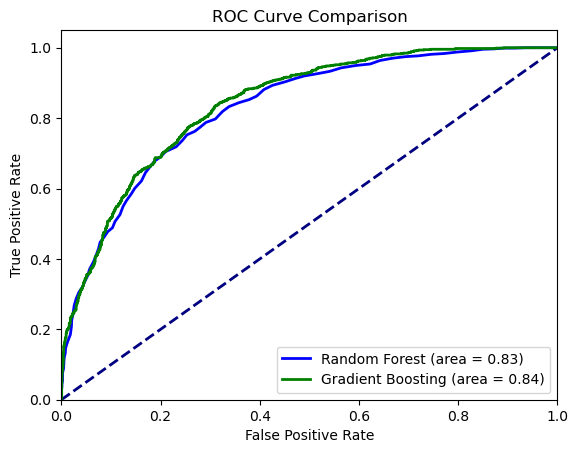

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier


# ROC Curve for RandomForestClassifier
y_pred_prob_rf = rf_classifier.predict_proba(X_test_encoded)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting ROC Curve for RandomForestClassifier
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
model=gb_classifier.fit(X_train_encoded, y_train)
y_pred_gb = gb_classifier.predict(X_test_encoded)

# ROC Curve for Gradient Boosting Classifier
y_pred_prob_gb = gb_classifier.predict_proba(X_test_encoded)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plotting ROC Curve for Gradient Boosting Classifier
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label='Gradient Boosting (area = %0.2f)' % roc_auc_gb)

accuracy_gbm = accuracy_score(y_test, y_pred_gb)
classification_rep_gbm = classification_report(y_test, y_pred_gb)

print("Gradient Boosting Classifier Accuracy:", accuracy_gbm)
print("Gradient Boosting Classifier Classification Report:\n", classification_rep_gbm)

# Show plot
plt.legend(loc="lower right")
plt.show()


In [27]:
from sklearn.model_selection import cross_val_score

rf_cv_scores = cross_val_score(rf_classifier, X_train_encoded, y_train, cv=5)
print("Random Forest - Cross-Validation Scores:", rf_cv_scores)
print("Random Forest - Average CV Score:", rf_cv_scores.mean())

gb_cv_scores = cross_val_score(gb_classifier, X_train_encoded, y_train, cv=5)
print("Gradient Boosting - Cross-Validation Scores:", gb_cv_scores)
print("Gradient Boosting - Average CV Score:", gb_cv_scores.mean())


Random Forest - Cross-Validation Scores: [0.7772093  0.77906977 0.79292694 0.76081899 0.77757096]
Random Forest - Average CV Score: 0.7775191922689839
Gradient Boosting - Cross-Validation Scores: [0.7827907  0.79023256 0.79571894 0.75942299 0.77617497]
Gradient Boosting - Average CV Score: 0.7808680294782863


/Users/luyu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/0s/3wm305ss39s661tjh72mh3h40000gn/T/ipykernel_29432/2926245142.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_data['Cluster'] = clusters


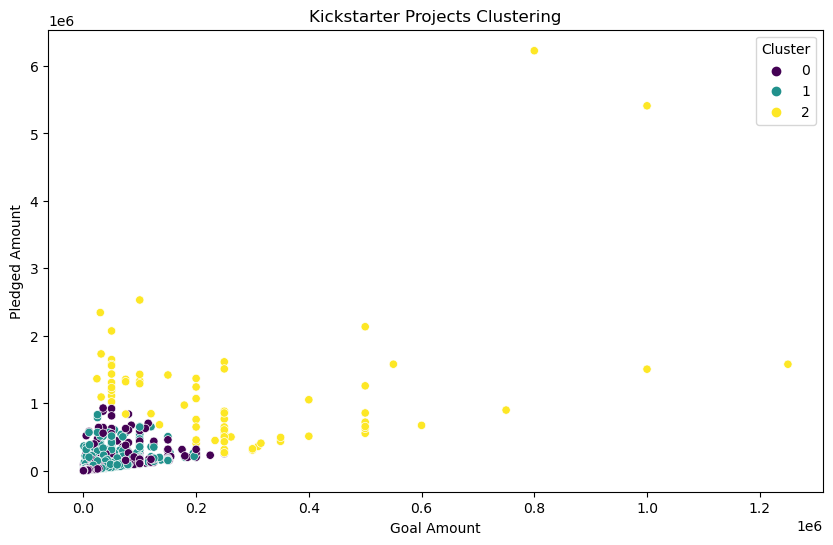

goal       pledged  launch_to_deadline_days  \
Cluster                                                         
0         26706.343467  7.401895e+04                46.677355   
1         14207.358416  3.254355e+04                28.340753   
2        275976.082192  1.119662e+06                37.958904   

         create_to_launch_days  
Cluster                         
0                   121.318637  
1                    28.786244  
2                    67.863014

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataset to include only projects with states 'successful' or 'failure'
filtered_data = kickstarter_df[kickstarter_df['state'].isin(['successful', 'failure'])]

# Selecting a few relevant features for clustering
features = ['goal', 'pledged', 'launch_to_deadline_days', 'create_to_launch_days']
clustering_data = filtered_data[features]

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# K-Means Clustering
# Using an arbitrary choice of 3 clusters; this can be optimized based on further analysis
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled_data)

# Adding the cluster labels to the dataset
clustering_data['Cluster'] = clusters

# Analyzing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustering_data, x='goal', y='pledged', hue='Cluster', palette='viridis')
plt.title('Kickstarter Projects Clustering')
plt.xlabel('Goal Amount')
plt.ylabel('Pledged Amount')
plt.show()

# Returning a summary of the clustering model
clustering_summary = clustering_data.groupby('Cluster').mean()
clustering_summary


In [30]:
##### Code for Grading Purposes


import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier


# import new dataset
kickstarter_data_path = "Kickstarter-Grading-Sample.xlsx"
test_df = pd.read_excel("Kickstarter-Grading-Sample.xlsx")

# Pre-processing

test_df = test_df[test_df['state'].isin(['successful', 'failed'])]

test_df = test_df.dropna(subset=['name'])
test_df['category'] = test_df['category'].fillna('Unknown')

test_df = test_df[test_df['goal'] > 0]
test_df['created_at'] = pd.to_datetime(test_df['created_at'])
test_df['launched_at'] = pd.to_datetime(test_df['launched_at'])
test_df['created_at_month'] = test_df['created_at'].dt.month
test_df['created_at_day'] = test_df['created_at'].dt.day
test_df['created_at_year'] = test_df['created_at'].dt.year
test_df['launched_at_month'] = test_df['launched_at'].dt.month
test_df['launched_at_day'] = test_df['launched_at'].dt.day
test_df['launched_at_year'] = test_df['launched_at'].dt.year
test_df['days_between_creation_and_launch'] = (test_df['launched_at'] - test_df['created_at']).dt.days

# Drop
columns_to_drop = ['id', 'pledged', 'backers_count', 'usd_pledged', 'spotlight', 'state_changed_at', 'deadline', 'created_at', 'launched_at']
test_df = test_df.drop(columns=columns_to_drop)

# encoded
categorical_columns = ['country', 'currency', 'category']  
test_encoded = pd.get_dummies(test_df, columns=categorical_columns)


# check align with X_train_encoded
X_test_aligned = test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# X Y
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_df['state'])

# Predict
y_pred = gb_classifier.predict(X_test_aligned)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy on new test set:", accuracy)
print("Classification Report:\n", classification_rep)


Accuracy on new test set: 0.7914285714285715
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      1134
           1       0.76      0.60      0.67       616

    accuracy                           0.79      1750
   macro avg       0.78      0.75      0.76      1750
weighted avg       0.79      0.79      0.79      1750



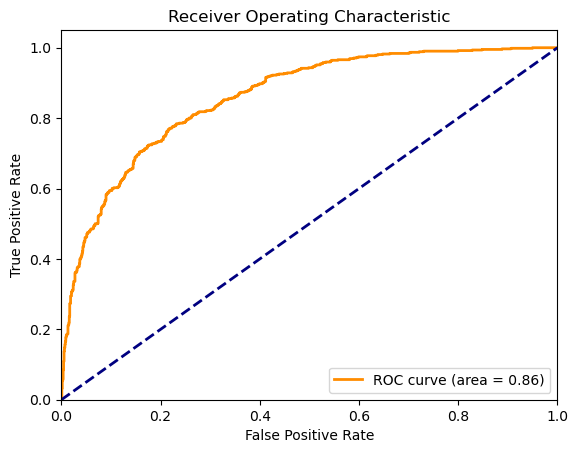

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# prob
y_pred_prob = gb_classifier.predict_proba(X_test_aligned)[:, 1]

#ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
